/Users/gleb/software/alignTrack/mpIIDESY/Curve/DS1_Minus/gm2tracker_ana.root
Extrapolation/vertices/station12/h_verticalPos
/Users/gleb/software/alignTrack/mpIIDESY/Curve/DS1_Truth/gm2tracker_ana.root
Extrapolation/vertices/station12/h_verticalPos
/Users/gleb/software/alignTrack/mpIIDESY/Curve/DS1_Plus/gm2tracker_ana.root
Extrapolation/vertices/station12/h_verticalPos
/Users/gleb/software/alignTrack/mpIIDESY/Curve/DS1_Minus/gm2tracker_ana.root
Extrapolation/vertices/station12/h_radialPos
/Users/gleb/software/alignTrack/mpIIDESY/Curve/DS1_Truth/gm2tracker_ana.root
Extrapolation/vertices/station12/h_radialPos
/Users/gleb/software/alignTrack/mpIIDESY/Curve/DS1_Plus/gm2tracker_ana.root
Extrapolation/vertices/station12/h_radialPos


Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file Extap.png has been created


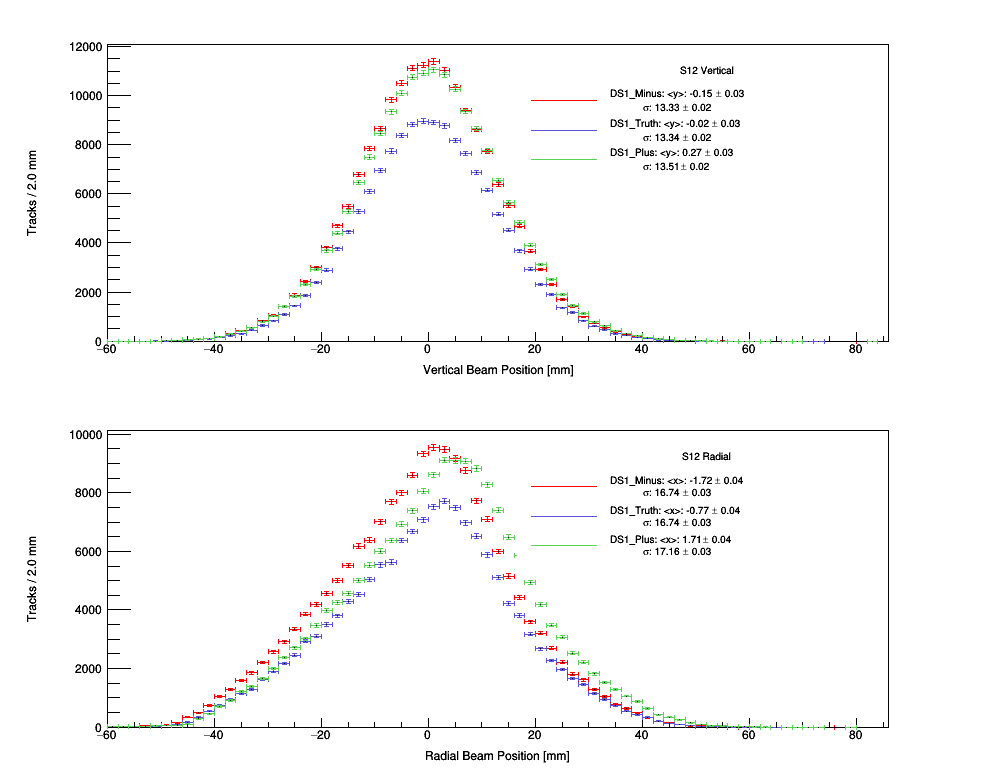

In [15]:
# Juoyer ROOT import 
import sys
sys.path.append("/usr/local/Cellar/root/6.14.04_2/lib/root")
# ROOT includes 
from ROOT import TH1D, TH2D, TF1, TCanvas, TFile, gStyle, TLegend, gROOT
   
#Define constant paths and labels 
plotPath = "Extrapolation/vertices/station"
topDir = "/Users/gleb/software/alignTrack/mpIIDESY/Curve/"
# states=("Truth", "Plus", "Minus")
states=("DS1_Minus", "DS1_Truth", "DS1_Plus")
stateN = len(states)
fileName="gm2tracker_ana.root"
# stations=[12, 18]
stations=[12]
stationN=len(stations)


#Final plots and canvases names (looped over i_plot)
canvasTitle = ["Vertical", "Radial"]
globalN=len(canvasTitle)
plotName=["h_verticalPos", "h_radialPos"] # TH1
results = ["<y>", "<x>"]
xTitles= ["Vertical Beam Position", "Radial Beam Position"]

#Legen labels (looped over i_state)
legendName = states
colorLine = [2, 9, 8] # red, blue, green
colorHisto = colorLine

#Open TFiles (looped over i_state)

fileArray = [] # keep files in scope
histArray = [] # keep hists in scope
legendArray = [] #keep legends in scope 

#Global empty containers to be filled for vertical or radial (in the main loop)
result = "-1"
mean = -1
mean_error = -1 
sd = -1 
sd_error = -1 
meanArray=[] # for the final FoM shift-nominal 

###### Plotting ##########
#Make new canvas for plots (4 in total)
canvas = TCanvas("", "", 1000, 800)
canvas.Divide(stationN, globalN)
i_plot = 1 

for i_station in range(0, stationN):
    for i_global in range(0, globalN):
        legend =  TLegend(0.9, 0.87, 0.52, 0.55)
        canvas.cd(i_plot) # cd for each station and rad/ver
        for i_state in range(0, stateN):
            
            #Get the TH1F 
            filePath = topDir + states[i_state] + "/" + fileName
            fullHistopath = plotPath + str(stations[i_station]) + "/" + plotName[i_global]
            print(filePath)
            print(fullHistopath)
            rootFile = TFile.Open(filePath)
            fileArray.append(rootFile)
            hist_1D = rootFile.Get(fullHistopath)
            histArray.append(hist_1D)
            
            #Rebin and minipulate the histo 
            hist_1D.Rebin()
            hist_1D.GetXaxis().SetRangeUser(-60, 85) # applying a maximum range cut 
            binN=hist_1D.GetBinWidth(1)
            
            hist_1D.SetTitle("")
            hist_1D.GetYaxis().SetTitle("Tracks / "+str(binN)+" mm")
            hist_1D.GetXaxis().SetTitle(xTitles[i_global] +" [mm]")       
            hist_1D.GetYaxis().SetTitleOffset(1.4)
            hist_1D.GetXaxis().SetTitleOffset(1.4);
            hist_1D.GetYaxis().CenterTitle()
            hist_1D.GetXaxis().CenterTitle()
            
            #Draw on canvas 
            hist_1D.SetLineColor(colorHisto[i_state])
            if (i_state == 0):
                hist_1D.Draw("E1")

            else:
                hist_1D.Draw("E1 same")

            #Get stats from hist 
            mean = round(hist_1D.GetMean(), 2)
            mean_error = round(hist_1D.GetMeanError(), 2)
            sd = round(hist_1D.GetRMS(), 2)
            sd_error = round(hist_1D.GetRMSError(), 2)
            result = results[i_global]
            legenObject = hist_1D
            meanArray.append(mean)


            #take care of the legend
            legenValue1 = str(legendName[i_state])+": "+str(result)+": "+str(mean)+" #pm "+str(mean_error) 
            legenValue2 = "#sigma: "+str(sd)+" #pm "+str(sd_error)
            legend.AddEntry(legenObject,"#splitline{"+str(legenValue1)+"}{           "+str(legenValue2)+"}","L") # make appropriate spacing 
            legend.SetTextSize(.028)
            legend.Draw("same")


        #Do some final massaging per pad 
        legend.SetHeader("S"+str(stations[i_station])+" "+canvasTitle[i_global], "C"); # option "C" allows to center the header
        legendArray.append(legend)
        meanArray=[]
        gStyle.SetOptStat(0)
        gStyle.SetOptFit(0)
        gStyle.SetLegendBorderSize(0)
        gStyle.SetLegendTextSize(0.15)
        i_plot+=1
        
canvas.Draw()
canvas.Print("Extap.png")